In [1]:
import math
import pickle
import os
import numpy as np
import pandas as pd
from numpy.linalg import inv,pinv
import matplotlib.pyplot as plt
import sys
from IPython import display
import time
%matplotlib inline

__author__ = 'Kiks'

def triM(*args):
    startM=args[0]
    for m in args[1:]:
        startM=startM.dot(m)
    return startM

def getX_min(x_row,o_row,timeD):
    xn1=x_row[0]+o_row[1]*math.cos(x_row[2])*timeD
    yn1=x_row[1]+o_row[1]*math.sin(x_row[2])*timeD
    thet1=x_row[2]+o_row[2]*timeD
    return np.array([xn1,yn1,thet1])
def getHfun(curX,lanX):
    v=math.sqrt((curX[0]-lanX[0])**2+(curX[1]-lanX[1])**2)
    w=math.atan2(lanX[1]-curX[1],lanX[0]-curX[0])-curX[2]
    return np.array([v,w])

def getH(curX,lanX,Hfun):
    VpoX=(curX[0]-lanX[0])/(Hfun[0])
    VpoY=(curX[1]-lanX[1])/(Hfun[0])
    denWder=( (lanX[0]-curX[0])**2 +(lanX[1]-curX[1])**2 )
    
    WpoX=(lanX[1]-curX[1])/denWder
    WpoY=-(lanX[0]-curX[0])/denWder
    
    WpoTh=-1
    return np.array([ [VpoX,VpoY,0],[WpoX,WpoY,-1] ])
    
def getA(x_row,o_row,timeD):
    a=np.eye(3,3)
    a[0,2]=-o_row[1]*math.sin(x_row[2])*timeD
    a[1,2]=o_row[1]*math.cos(x_row[2])*timeD
    return a
def getP_min(AK,PK_1,QK):
    return triM(AK,PK_1,AK.T) + \
    (QK)

def getK(PK_,HK,RK):
    return triM(PK_,HK.T,
           inv(  triM(HK,PK_,HK.T)
                   +RK))

def getX_post(x_row,KK,z_row,h_row):
    return x_row+triM(KK,(z_row-h_row))

def getP(I,KK,HK,PK_):
    return  (I- np.dot(KK,HK)).dot(PK_)
def absdist(x1,x2):
    return abs(x1[0]-x2[0])+abs(x1[1]-x2[1])

def getbaseX(groun,odom):
    if len(odom)<1:
        print('no ground baseX')
        sys.exit(-5)
    fin=np.where(groun[:,0]<=odom[0,0])[0]
    if len(fin)<1:
        print("no baseX for first odom")
        sys.exit(-5)
        #return getbaseX(groun,odom[1:])
    return fin[-1]
def euc_dist(a,b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 )

In [2]:
def process(groun,odom,meas,btwn_Ms,lanDik,Qerror=1e-5,Rerror=1e-1,isCorrect=True):
    fInd1=getbaseX(groun,odom)
    print(fInd1)
    #sys.exit(-6)
    
    xCalc=np.zeros((odom.shape[0]+1,odom.shape[1]),dtype=float)
    xCalc[0]=groun[fInd1,1:]
    curTime=groun[fInd1,0]
    
    xTime=np.zeros((odom.shape[0]+1,),dtype=float)
    xTime[0]=curTime
    
    startInd=0
    lenM=len(meas)
    # PMat=np.zeros((odom.shape[0]+1,odom.shape[1]),dtype=float)
    PMat=np.zeros((3,3),dtype=float)

    QMat=np.eye(3,dtype=float)*Qerror
    RMat=np.eye(2)*Rerror
    HMat=np.eye(3)
    IMat=np.eye(3,3)

    postEd=np.zeros((odom.shape[0]+1,),dtype=int)
    postEd[0]=1
    for i,mind in enumerate(np.array(btwn_Ms,dtype=int)):
        for insInd in range(startInd,startInd+mind):
            timeD=odom[insInd,0]-curTime
            xCalc[insInd+1]=getX_min(xCalc[insInd],odom[insInd],timeD)
            xTime[insInd+1]=odom[insInd,0]
            
            curA=getA(xCalc[insInd+1],odom[insInd],timeD)
            PMat=getP_min(curA,PMat,QMat)

            curTime=odom[insInd,0]
        startInd+=mind
        
        if isCorrect and mind!=0 and i<lenM and  int(meas[i][1]) in lanDik:
            postEd[startInd]=1
            #print(startInd,xCalc[startInd],PMat)
            
            hFun=getHfun(xCalc[startInd],lanDik[ int(meas[i][1]) ])
            HMat=getH(xCalc[startInd],lanDik[ int(meas[i][1])],hFun)
            
            try:
                KMat=getK(PMat,HMat,RMat)
            except:
                print(i)
                sys.exit(-10)
            
            
            xCalc[startInd]=getX_post(xCalc[startInd],KMat,
                                      meas[i][2:],hFun)           
            #print("\n============\n",getK(PMat,HMat,RMat))
            PMat=getP(IMat,KMat,HMat,PMat)
            
            #print('\n\n===================\n',
            #      startInd,xCalc[startInd],KMat,PMat,HMat,hFun,meas[i,:],meas[i][2:]-hFun)
            #sys.exit(-20)
            
    return postEd,xCalc,xTime,fInd1

In [3]:
def calcError(groun,fInd,xCalc,xTime,postEd):
    oldG=0
    upper=20
    lower=-20
    sumE=0.0
    print("shapes xcalc and xtime and posted",xCalc.shape,xTime.shape
          ,postEd.shape,flush=True)
    
    grounS=groun[fInd:]
    #np.clip(xCalc,lower,upper)
    txCalc=np.vstack((xCalc.T,xTime,postEd)).T
    for ind,(old,new) in enumerate(zip(grounS,grounS[1:])):
       
        timeThO=old[0]
        timeThN=new[0]
        testxCalc=txCalc[(txCalc[:,3]<=timeThN) & (txCalc[:,3]>timeThO),:]
        
        if len(testxCalc)>0:
            avgX=np.average(testxCalc[:,:2],0)
            avgG=np.average(np.vstack((old[1:],new[1:])),0)
            #print(avgX,avgG,euc_dist(avgX,avgG))
            sumE+=euc_dist(avgX,avgG)
            
        #print(old,new,testxCalc.shape,testxCalc)
        #if ind%10==6: sys.exit(-5)
    return sumE

In [4]:
def plotMov(oldG,newG,oldO,newO,oldOO=None,newOO=None):
    #print(oldG.shape,newG.shape,oldO.shape,newO.shape)
    #sys.exit(-5)
    plt.plot(oldG[:,1],oldG[:,2],color=(0.5647,0.933,0.5647,0.7058),linestyle='--')
    plt.plot(newG[:,1],newG[:,2],'g-')
    plt.scatter(newG[-1,1],newG[-1,2],color='green',s=20)
    
    plt.plot(oldO[:,0],oldO[:,1],color= (1.0, 0.6, 0.6),linestyle='--')
    if oldOO!= None: plt.plot(oldOO[:,0],oldOO[:,1],
                              color= (1.0,165/255,0),linestyle='--')
    # magenta where it actually is posted + final dot
    if len(newO)>0:
        koiC=np.where(newO[:,4]>0.0)[0]
        
        plt.scatter(newO[-1,0],newO[-1,1],color='red',s=50)
        plt.scatter(newO[koiC,0],newO[koiC,1],color='magenta',s=40)      
    if  newOO!= None and len(newOO)>0:    
        plt.scatter(newOO[-1,0],newOO[-1,1],color='orange',s=50)
        
    plt.plot(newO[:,0],newO[:,1],'r-')
    if newOO!= None: plt.plot(newOO[:,0],newOO[:,1],
                              color= (1.0,165/255,0))
def plotLand(lanList):
    plt.scatter(lanList[:,0],lanList[:,1],color='blue',s=50)

In [5]:
def plotAll(groun,xCalc,xTime,postEd,stepRun,maxgrounH,xyAxes,timeStep=1,
            xCalcO=None):
    maxgrounH=60000
    #timeTh=groun[grounH,0]
    oldG=0
    upper=20
    lower=-20
    print("shapes xcalc and xtime and posted",xCalc.shape,xTime.shape,postEd.shape)

    grounS=groun[fInd:]
    lanList=np.array(list(landDik.values()))

    xCalc2=np.clip(xCalc,lower,upper)
    xCalc3=np.vstack((xCalc2.T,xTime,postEd)).T
    if xCalcO!=None:
        np.clip(xCalcO,lower,upper,xCalcO)
        xCalcO=np.vstack((xCalcO.T,xTime,postEd)).T
    oldpXO=np.zeros((0,2))
    pxCalcO=None
    
    print(xCalc3.shape)
    p1xCalc=xCalc3#[np.where(postEd==1)]
    print(p1xCalc[:5,4]==1.0)
    oldpX=np.zeros((0,2))
    oldPlotG=np.zeros((0,3))

    #p2xCalc=p1xCalc[p1xCalc[:,3]<timeTh,:]
    sites=[]

    plt.figure(figsize=(20,20))
    plt.subplots_adjust(top=0.85)
    axes=plt.gca()
    axes.set_xlim(xyAxes[0])
    axes.set_ylim(xyAxes[1])
    #plt.subplot(211)
    #plt.plot(np.array(p1xCalc[:,3]<timeTh,dtype=int)[:5])
    for ind,i in enumerate(range(50,maxgrounH,stepRun)):
        if ind%1==0: 
            plt.clf()
            axes=plt.gca()
            axes.set_xlim(xyAxes[0])
            axes.set_ylim(xyAxes[1])
        grounH=i
        print('     \r',grounH,end='',flush=True)
        timeTh=grounS[grounH,0]
        timeThp=grounS[oldG,0]
        p3xCalc=p1xCalc[(p1xCalc[:,3]<=timeTh) & (p1xCalc[:,3]>timeThp),:]
        if xCalcO!=None: pxCalcO=xCalcO[(p1xCalc[:,3]<=timeTh) 
                                        & (p1xCalc[:,3]>timeThp),:]
        
        gBatch=grounS[oldG:grounH,:]

        oldG=i
        print(p3xCalc.shape)
        plotMov(oldPlotG,gBatch,oldpX,p3xCalc,oldpXO,pxCalcO)
        plotLand(lanList)

        sites.append([oldG,grounH,timeThp,timeTh,len(p3xCalc)])
        
        oldpX=p3xCalc
        if xCalcO!=None: oldpXO=pxCalcO
        
        oldPlotG=gBatch

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(timeStep)

    #print (sites)
    sites=np.array(sites)

In [ ]:
i=1

oName='datasets/Robot{}_Odometry.dat'.format(i)
mName='datasets/Robot{}_Measurement.dat'.format(i)
gName='datasets/Robot{}_Groundtruth.dat'.format(i)
lName='datasets/Landmark_Groundtruth.dat'
bName='datasets/Barcodes.dat'

namesOdom="Time[s]    forward_velocity[m/s]    angular_velocity[rad/s]".split()
odom=pd.read_csv(oName,sep=r"\s*",skiprows=4,names=namesOdom,engine='python')

namesMeas="Time[s]    Subject_#    range[m]    bearing[rad]".split()
meas=pd.read_csv(mName,sep=r"\s*",skiprows=4,names=namesMeas,engine='python')

namesGroun="Time[s]    x[m]    y[m]    orientation[rad]".split()
groun=pd.read_csv(gName,sep=r"\s*",skiprows=4,names=namesGroun,engine='python')

namesLand=" Subject#    x[m]    y[m]    xstd-dev[m]    ystd-dev[m]".split()
land=pd.read_csv(lName,sep=r"\s*",skiprows=4,names=namesLand,engine='python')

namesBar=" Subject#    Barcode#".split()
bar=pd.read_csv(bName,sep=r"\s*",skiprows=4,names=namesBar,engine='python')

odom=np.array(odom.values)
meas=np.array(meas.values)
groun=np.array(groun.values)
land=np.array(land.values)
bar=np.array(bar.values)

print(len(meas),len(set(meas[:,0])))

barDik={int(row[0]):int(row[1]) for row in bar}
landDik={barDik[int(row[0])]:row[1:3] for row in land}

with open('betw_{}.meas'.format(i),"rb") as f:
    bt_Ms,abt_Ms=pickle.load(f)

with open('betw_{}.groun'.format(i),"rb") as f:
    bt_Gt=pickle.load(f)

print(landDik)

startI=0
startO=sum(abt_Ms[:startI])
print(startI,sum(abt_Ms[startI:]),len(odom[startO:]),len(abt_Ms),len(meas))
plt.figure(figsize=(20,10))

plt.plot(abt_Ms[7135:])

postEd,xCalc,xTime,fInd=process(groun,odom[startO:],meas[startI:],
                                abt_Ms[startI:],landDik,Qerror=1e-5,Rerror=1e-3)
#postEdO,xCalcO,xTimeO,fIndO=process(groun,odom[startO:],meas[startI:],
#                                abt_Ms[startI:],landDik,False,Qerror=1e-5,1e-1)

plotAll(groun,xCalc,xTime,postEd,500,len(groun),[[-1,6],[-6.5,6.5]],timeStep=0.8)


[[  1.00000000e-05   1.00000000e-01   6.48340436e+04]
 [  1.00000000e-05   8.88900000e-02   6.52791196e+04]
 [  1.00000000e-05   7.77800000e-02   6.74067227e+04]
 [  1.00000000e-05   6.66700000e-02   6.87658006e+04]
 [  1.00000000e-02   2.22300000e-02   6.96045941e+04]]


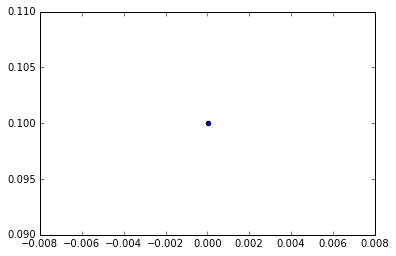

In [65]:
def saveL(resL):
    if not os.path.isfile('resList.ers'):
        with open('resList.ers','wb') as f:
            pickle.dump(resL,f)

resList.sort(key=lambda x: x[2])
resLista=np.array(resList)

saveL(resLista)

print(resLista[:5])
plt.scatter(resLista[:1,0],resLista[:1,1])

In [ ]:
def calcErrs(qL=10,rL=10)
    resList=[]
    for indq,q in enumerate(np.linspace(1e-5,1e-2,qL)):
        for r in np.linspace(1e-5,1e-1,rL):
            postEd,xCalc,xTime,fInd=process(groun,odom[startO:],meas[startI:],
                                    abt_Ms[startI:],landDik,Qerror=q,Rerror=r)
            resList.append( (q,r,calcError(groun,fInd,xCalc,xTime,postEd)))
            print(indq,flush=True)
            #sys.exit(-5)